In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pandas as pd
import json
ry2kcalmol = 313.75470835207074
eh2kcalmol = 2.0*ry2kcalmol
ry2ev = 13.60569301
kcalmol2ev = 0.043
au2ang = 0.52917721067121
from pymatgen.analysis import eos
from ase.io import read
import copy

In [3]:
sns.set_style("darkgrid")

In [4]:
def get_energy_qcore(filename):
    with open(filename) as fi:
        lines=fi.readlines()
    for line in lines:
        if "TOTAL ENERGY" in line:
            final_energy=float(line.strip().split()[2])*eh2kcalmol
    return final_energy

In [5]:
def get_energy_espresso(filename):
    final_energy = None
    try:
        data=open(filename).readlines()
        for line in data:
            if line.startswith("!"):
                final_energy = float(line.split()[4])*ry2kcalmol
    except :
        print(filename)
        pass
    return final_energy

In [6]:
def get_energy_xtb(filename):
    with open(filename) as fi:
        lines=fi.readlines()
    for line in lines:
        if "TOTAL ENERGY" in line:
            final_energy=float(line.strip().split()[3])*eh2kcalmol
    return final_energy

In [7]:
def get_energy_pqcore(filename):
    final_energy=None
    with open(filename) as fi:
        lines=fi.readlines()
    for line in lines:
        if "Total energy" in line:
            final_energy=float(line.strip().split()[2])*eh2kcalmol
    if not final_energy:
        print(filename)
    return final_energy

In [8]:
def get_energy_pqcore_json(filename):
    final_energy=None
    try:
        with open(filename) as fi:
            data=json.load(fi)
        if data["calc"]["converged"]:
            final_energy = data["calc"]["energy"]*eh2kcalmol
        
    except :
        print(filename)
        pass
    if not final_energy:
        print(filename)
    return final_energy

In [9]:
def get_volume_espresso(filename):
    volume = None
    try:
        data=open(filename).readlines()
        for line in data:
            if "unit-cell volume"   in line:
                volume = float(line.strip().split()[3])
    except :
        print(filename)
        pass
    return volume*np.power(au2ang,3)

In [10]:
def get_volume_qcore_json(data):
    deg2rad = np.pi/180.0
    a = data["calc"]["_input"]["structure"]["lattice"]["a"]["value"]
    b = data["calc"]["_input"]["structure"]["lattice"]["b"]["value"]
    c = data["calc"]["_input"]["structure"]["lattice"]["c"]["value"]
    alpha = data["calc"]["_input"]["structure"]["lattice"]["alpha"]["value"]*deg2rad
    beta = data["calc"]["_input"]["structure"]["lattice"]["beta"]["value"]*deg2rad
    gamma = data["calc"]["_input"]["structure"]["lattice"]["gamma"]["value"]*deg2rad
    vol = a*b*c*np.sqrt(1+2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)-np.square(np.cos(alpha))
                        -np.square(np.cos(beta))-np.square(np.cos(gamma)))
    return vol

In [11]:
def get_energy_volume_pqcore_json(filename):
    final_energy=None
    volume = None
    try:
        with open(filename) as fi:
            data=json.load(fi)
        if data["calc"]["converged"]:
            final_energy = data["calc"]["energy"]*eh2kcalmol
            volume = get_volume_qcore_json(data)
    except :
        print(filename)
        pass
    return final_energy, volume

# post process -- compute K0

In [12]:
names = [n.strip() for n in open("names.txt").readlines()]
df_dft = pd.read_csv("results_dft.csv")
df_xtb = pd.read_csv("results_xtb.csv")
df_xtb.dropna(axis=0, inplace=True)
df_dft.dropna(axis=0, inplace=True)

## DFT

/var/folders/fx/xvl67r056l302b935842xysw0000gq/T/ipykernel_90846/1317060348.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_dft["Bulk modulus [GPa]"][df_dft["name"]==name] = k0
/var/folders/fx/xvl67r056l302b935842xysw0000gq/T/ipykern

ORIVUI


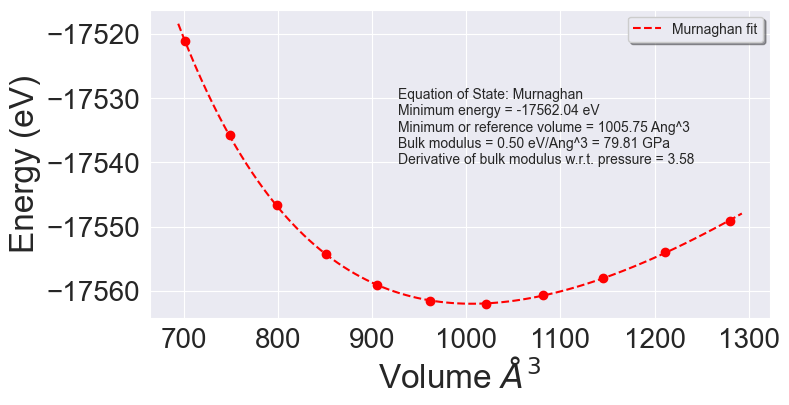

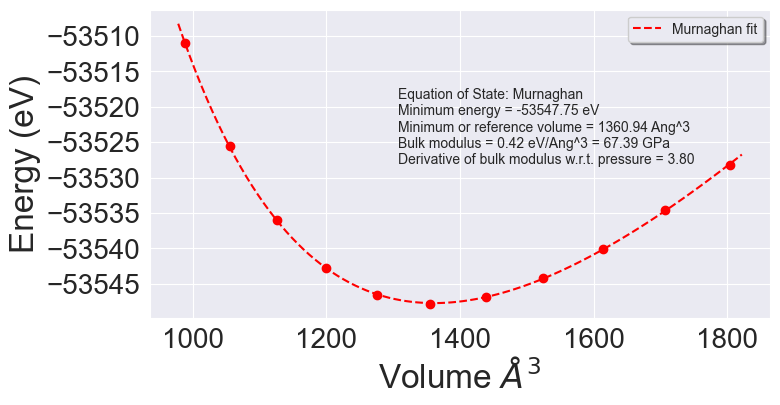

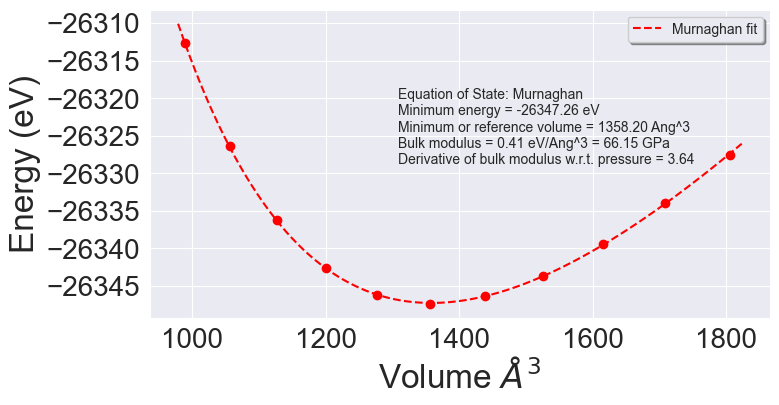

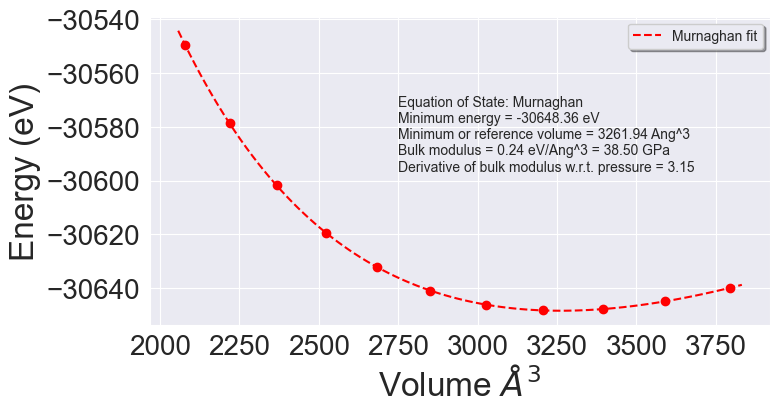

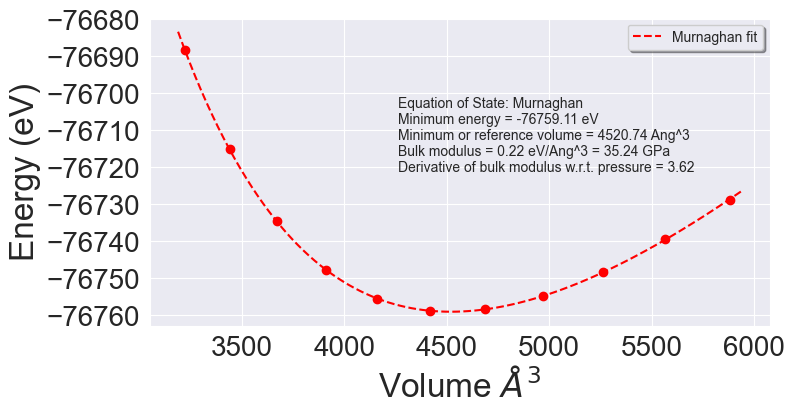

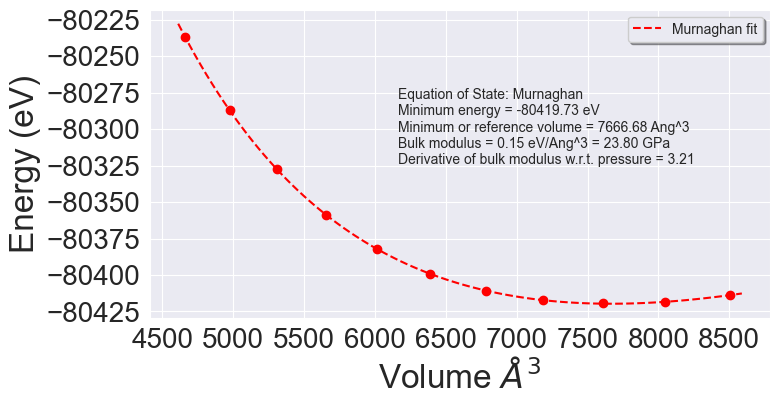

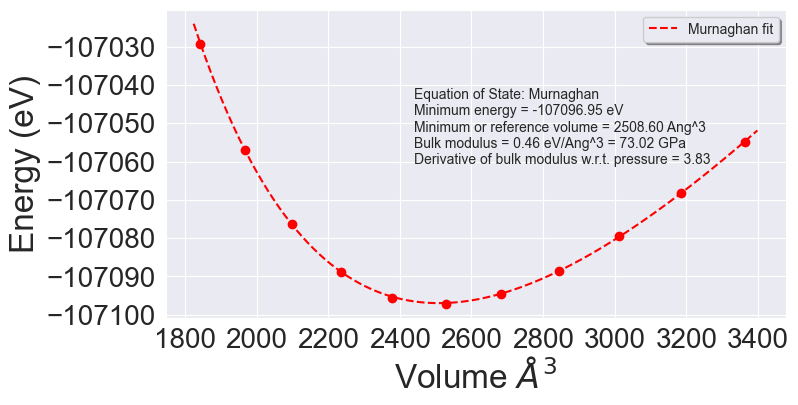

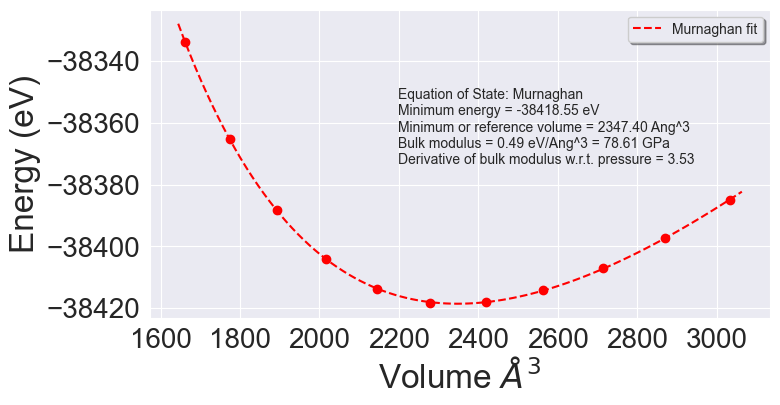

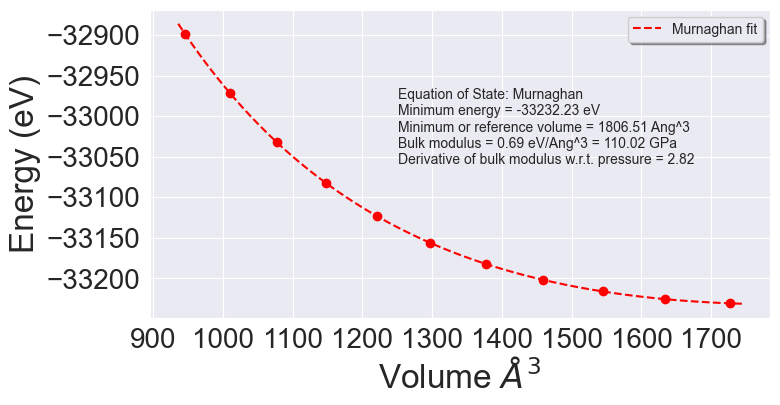

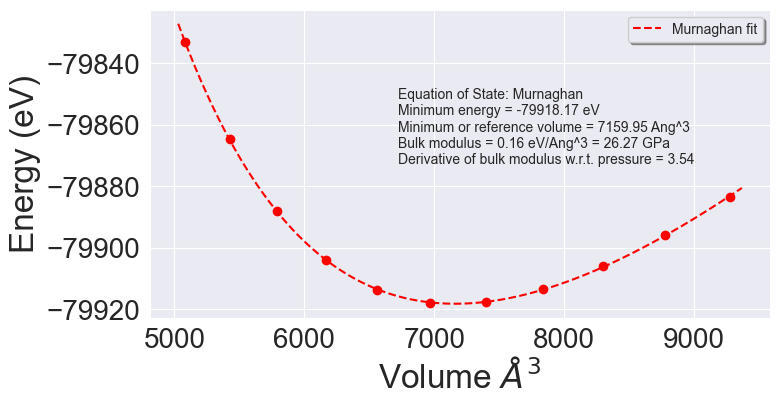

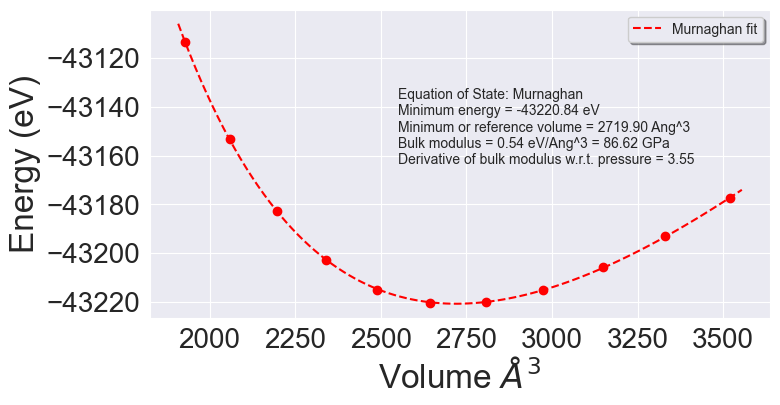

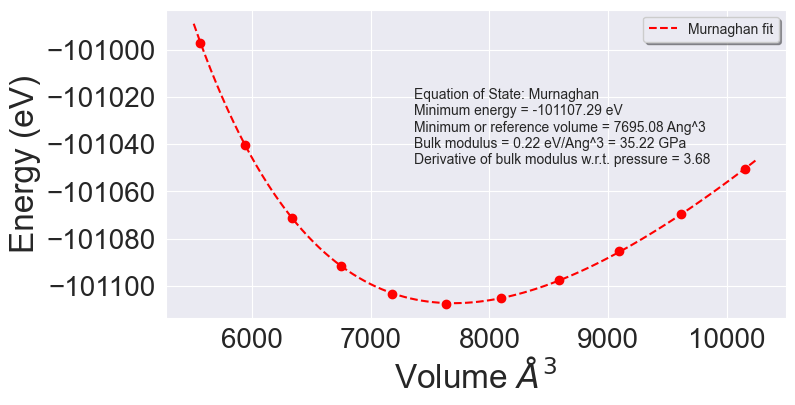

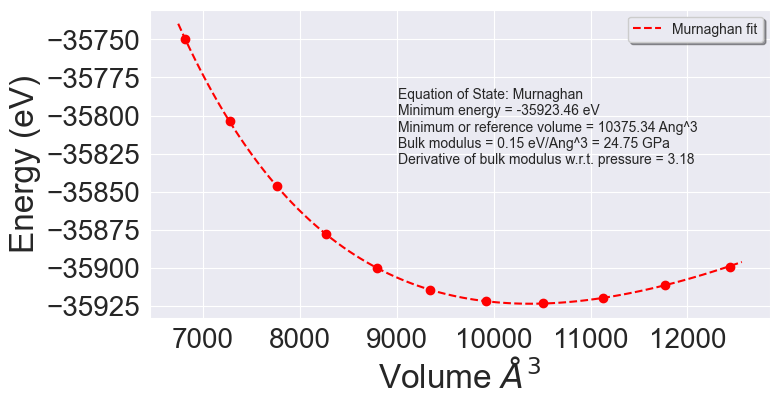

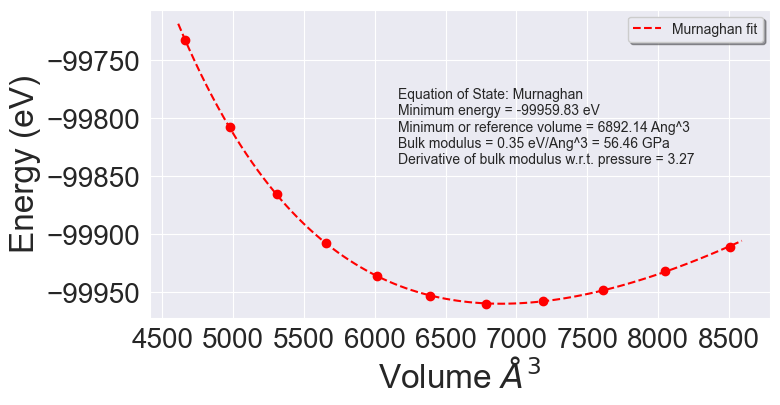

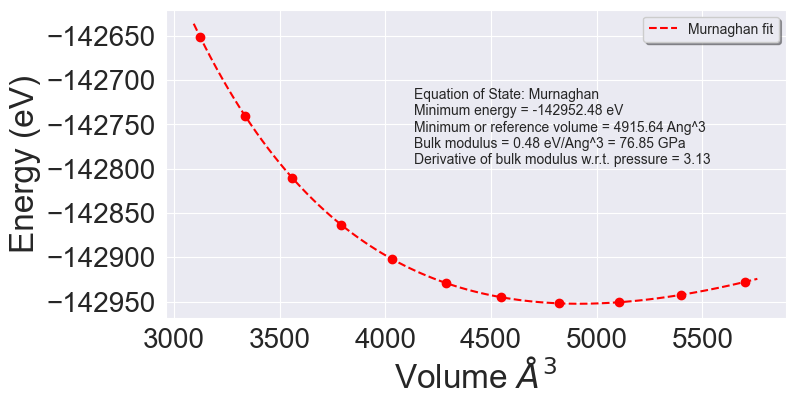

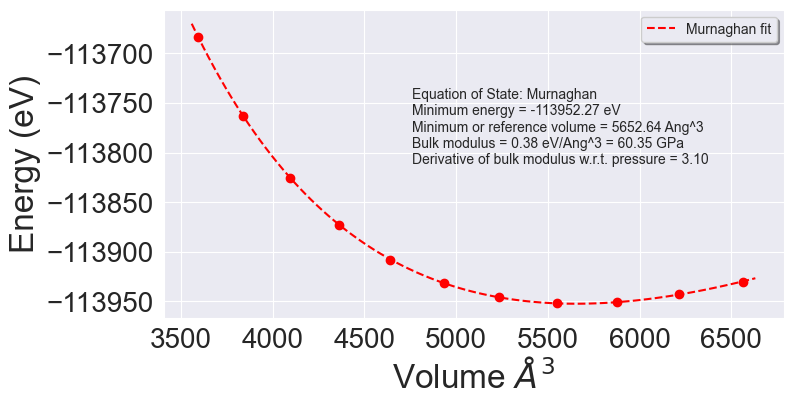

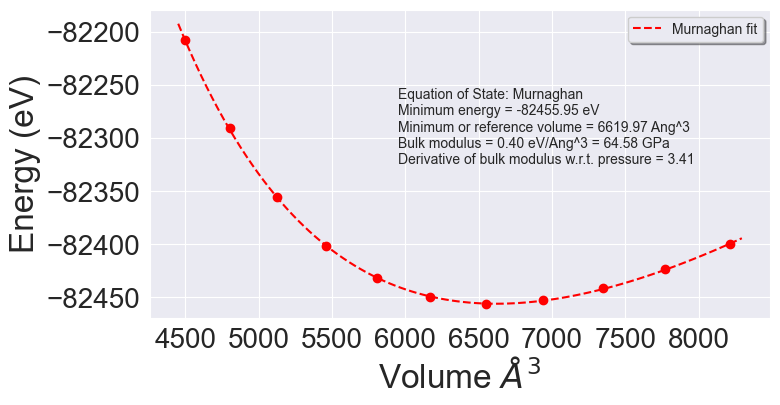

In [13]:
df_dft["Bulk modulus [GPa]"] = 0
for name in names:
    try:
    #     if name == "ORIVUI":
    #         continue
        vols = df_dft.loc[df_dft["name"]==name]["volume"]
        energies = df_dft.loc[df_dft["name"]==name]["energy [kcal/mol]"]*kcalmol2ev
        eos_system = eos.EOS(eos_name='murnaghan')
        eos_fit = eos_system.fit(vols, energies)
        k0 = eos_fit.b0_GPa
        df_dft["Bulk modulus [GPa]"][df_dft["name"]==name] = k0
        eos_fit.plot()
        plt.savefig("EOS_DFT/{}.png".format(name),dpi=600,bbox_inches="tight")
        plt.savefig("EOS_DFT/{}.pdf".format(name),bbox_inches="tight")
    except:
        print(name)
        continue

/var/folders/fx/xvl67r056l302b935842xysw0000gq/T/ipykernel_90846/2398332046.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_xtb["Bulk modulus [GPa]"][df_xtb["name"]==name] = k0
/var/folders/fx/xvl67r056l302b935842xysw0000gq/T/ipykern

UPOZAB
BOHWIG


/Users/alexanderbuccheri/Codes/tb_benchmarking/.venv/lib/python3.11/site-packages/pymatgen/analysis/eos.py:59: RankWarning: Polyfit may be poorly conditioned
  a, b, c = np.polyfit(self.volumes, self.energies, 2)


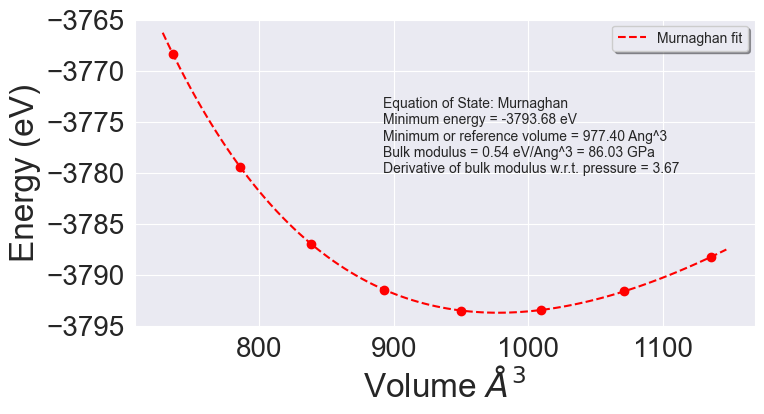

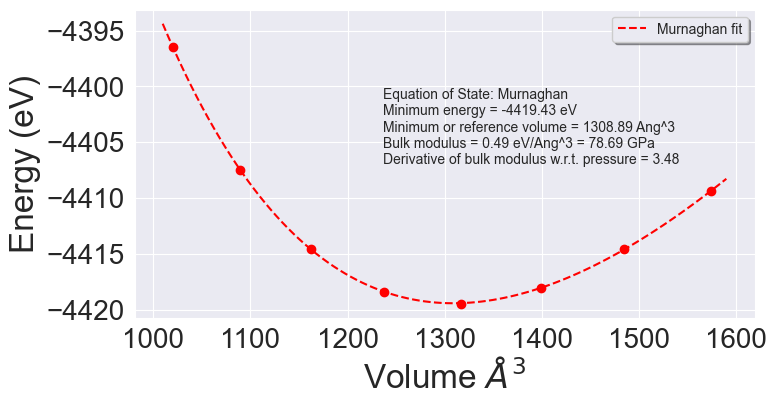

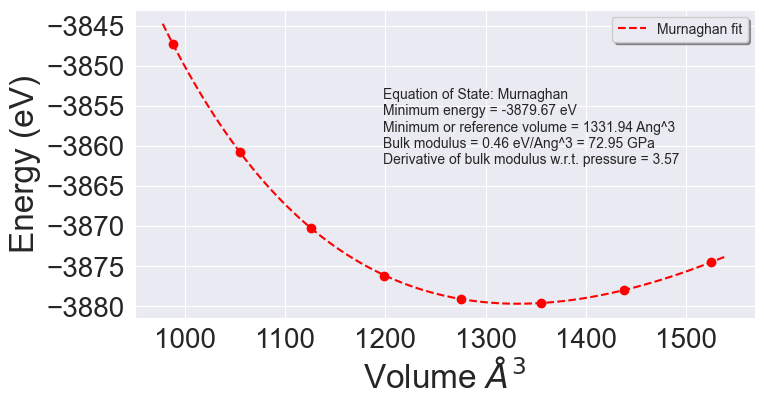

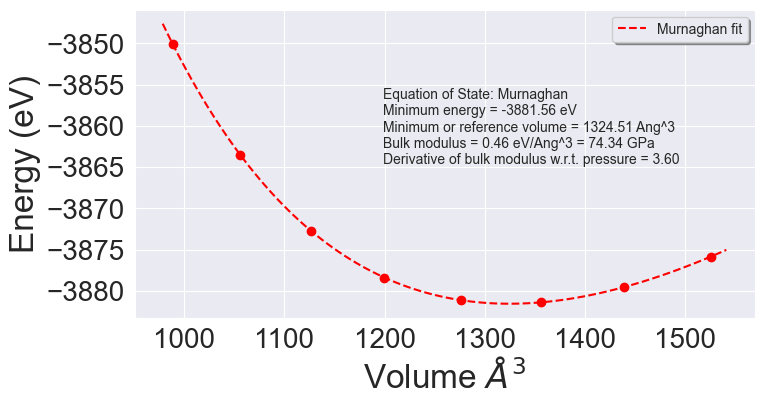

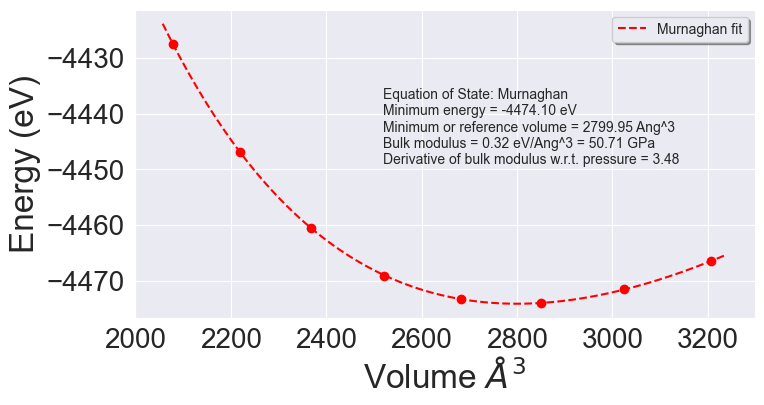

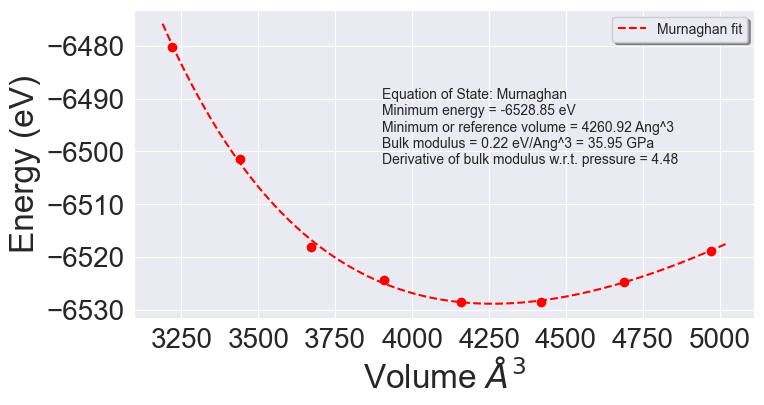

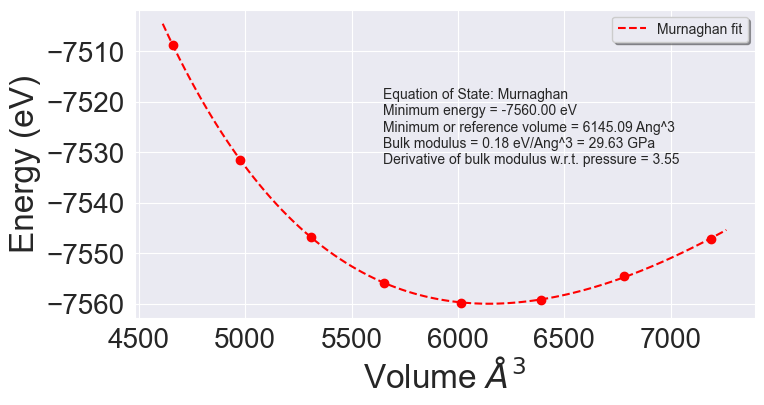

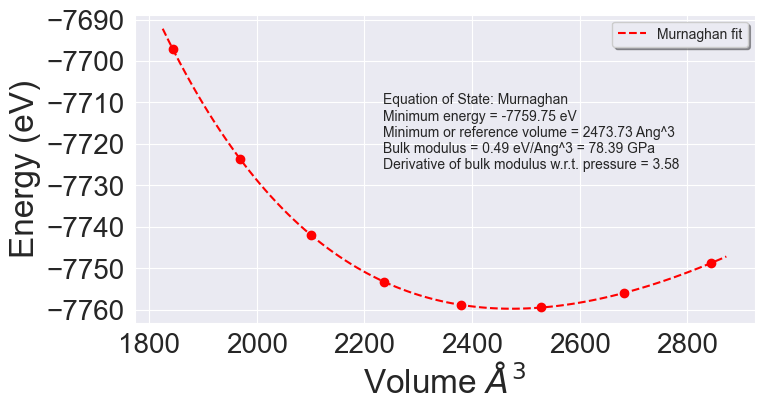

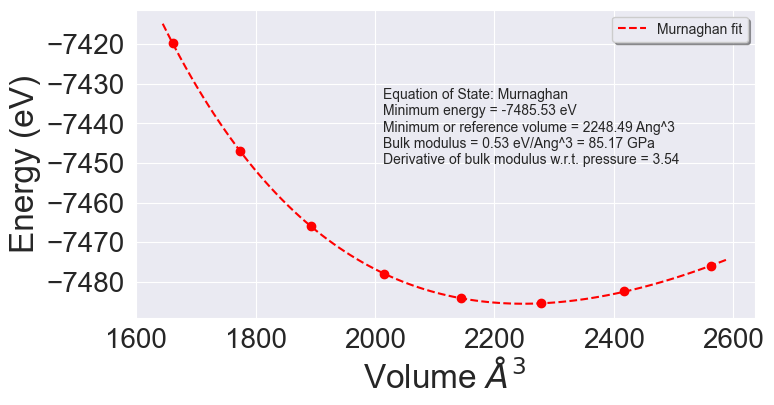

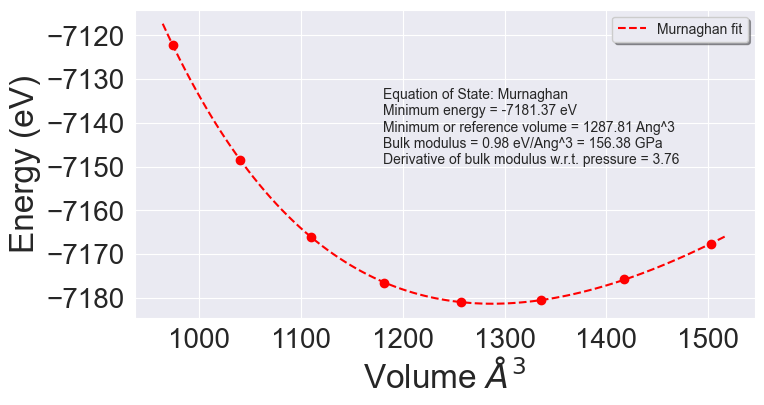

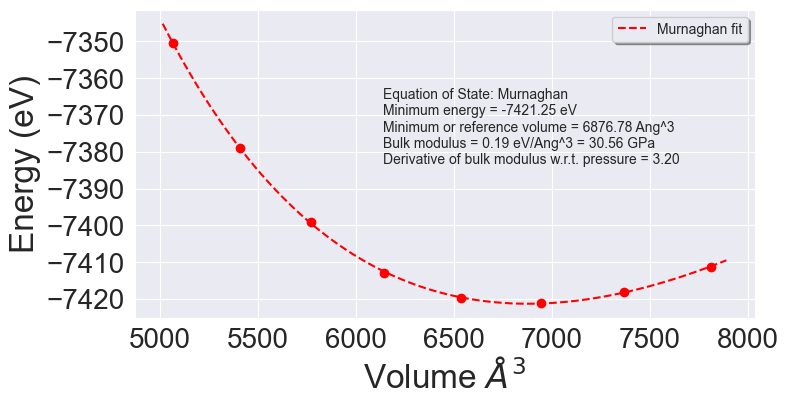

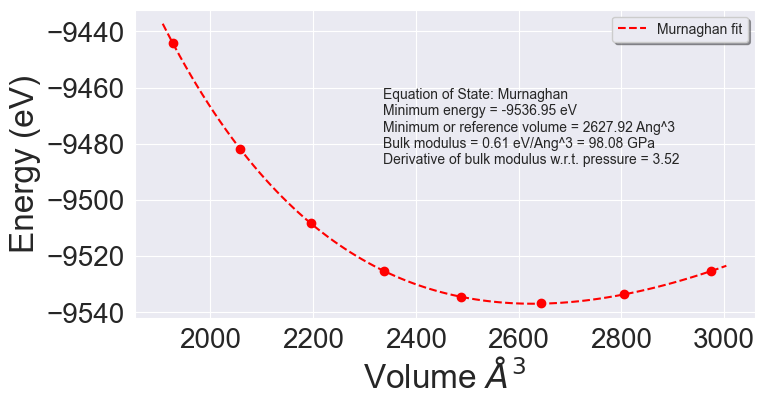

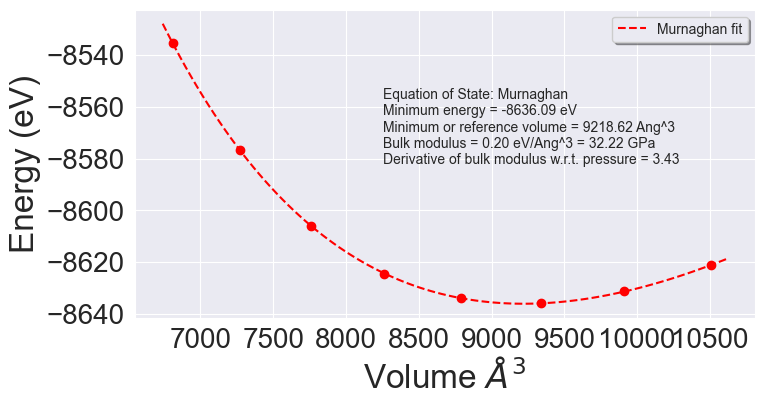

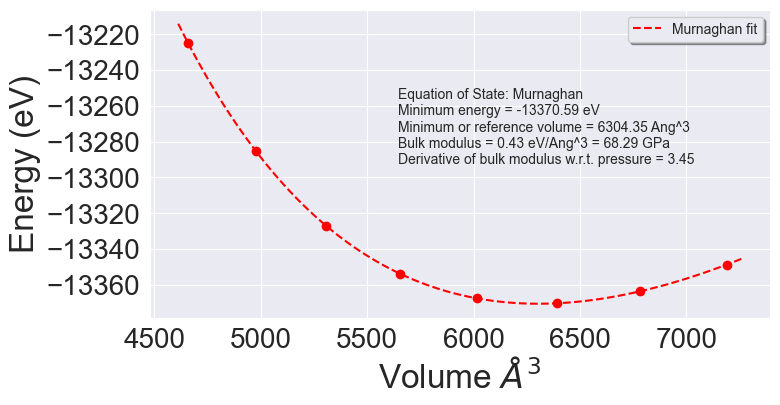

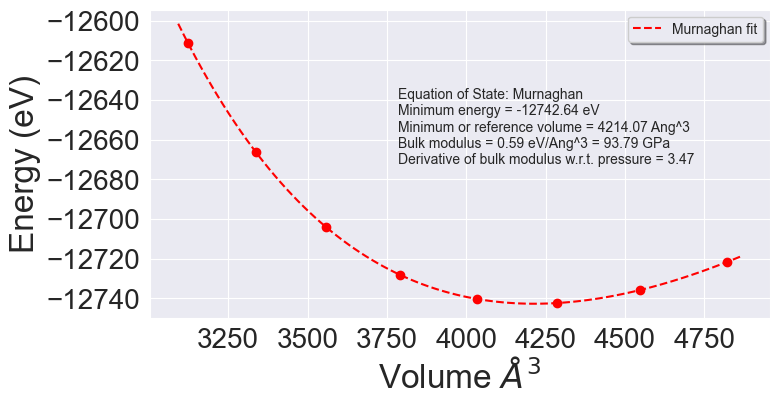

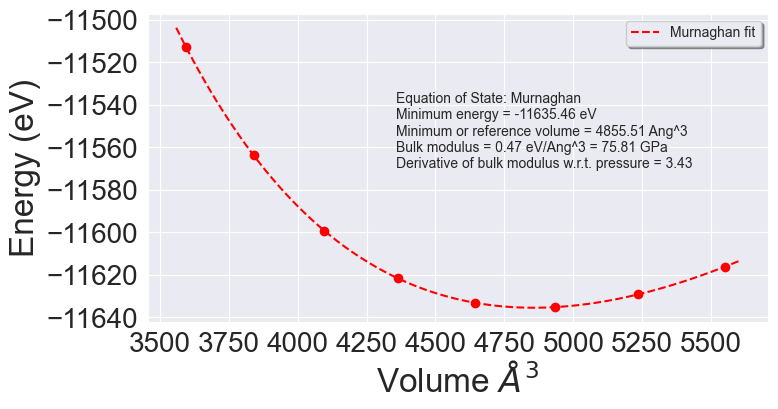

In [14]:
failed = []
df_xtb["Bulk modulus [GPa]"] = 0
for name in names:
    try:
    #     if name == "ORIVUI":
    #         continue
        vols = df_xtb.loc[df_xtb["name"]==name]["volume"]
        energies = df_xtb.loc[df_xtb["name"]==name]["energy [kcal/mol]"]*kcalmol2ev
        v_e = np.vstack([vols,energies]).T
        v_e = v_e[v_e[:, 0].argsort()]
        eos_system = eos.EOS(eos_name='murnaghan')
        eos_fit = eos_system.fit(v_e[:-3,0], v_e[:-3,1])
        k0 = eos_fit.b0_GPa
        df_xtb["Bulk modulus [GPa]"][df_xtb["name"]==name] = k0
        eos_fit.plot()
        plt.savefig("EOS_xTB/{}.png".format(name),dpi=600,bbox_inches="tight")
        plt.savefig("EOS_xTB/{}.pdf".format(name),bbox_inches="tight")
    except:
        print(name)
        failed.append(name)
        continue

# Comparing DFT with xTB

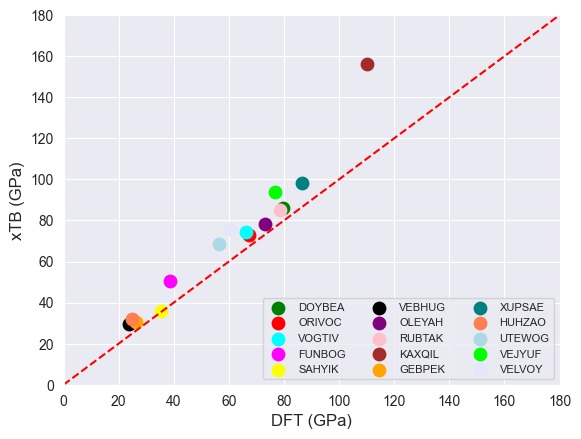

In [15]:
count = 0
names_converged_new = []
converged_pairs = []
colorlist = ['blue', 'green', 'red', 'cyan', 'magenta', 
'yellow', 'black', 'purple', 'pink', 'brown', 
'orange', 'teal', 'coral', 'lightblue', 'lime', 
'lavender', 'turquoise', 'darkgreen', 'tan', 
'salmon', 'gold', 'lightpurple', 'darkred', 'darkblue']
for name in names:
    try:
        b_xtb = df_xtb.loc[df_xtb["name"]==name]["Bulk modulus [GPa]"].values[0]
        b_dft = df_dft.loc[df_dft["name"]==name]["Bulk modulus [GPa]"].values[0]
        if b_xtb > 0 and b_dft >0:
            count+=1
            names_converged_new.append(name)
            converged_pairs.append([b_dft, b_xtb])
            plt.scatter(b_dft,b_xtb,c=colorlist[count],s=80,alpha=1, label=name)
    except:
        continue

xr = np.linspace(0,200,100)
plt.plot(xr,xr,"--r")
plt.xlim([0,180])
plt.ylim([0,180])
plt.xlabel("DFT (GPa)",fontsize=12)
plt.ylabel("xTB (GPa)",fontsize=12)
plt.legend(loc='lower right', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(1, 0))
plt.savefig("xtb_dft.pdf",bbox_inches="tight")
plt.savefig("xtb_dft.png",dpi=600,bbox_inches="tight")

In [13]:
len(names_converged_new)
a = np.array(converged_pairs)
np.sum(np.abs(a[0] - a[1]) / a[0])/15

0.020507829227831686

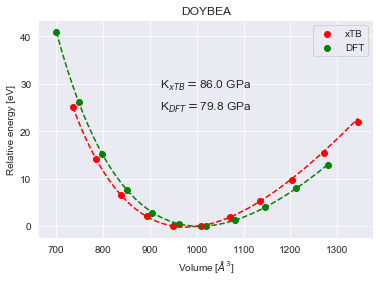

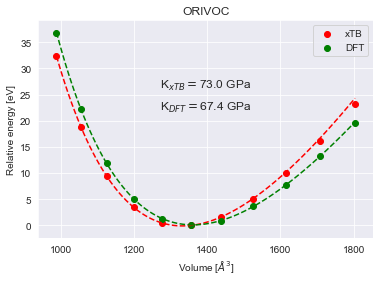

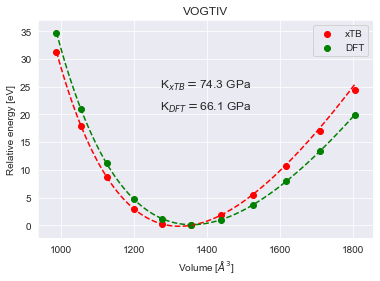

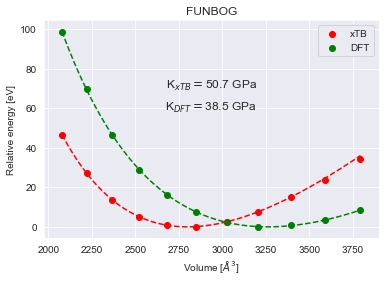

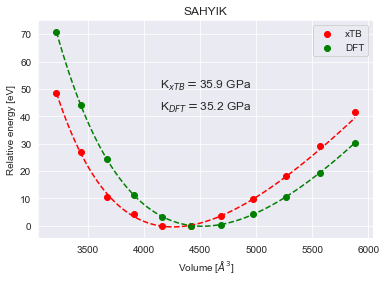

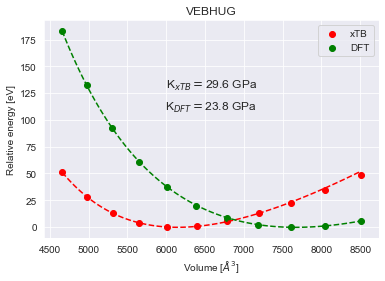

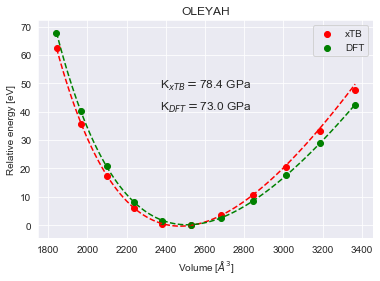

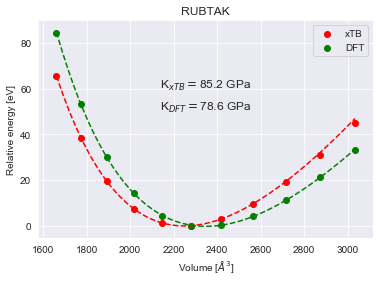

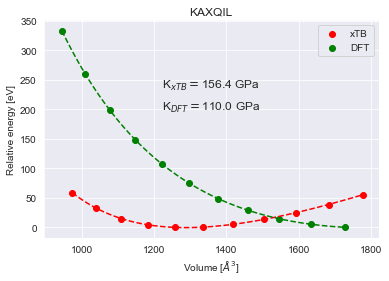

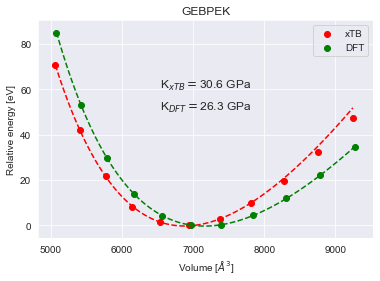

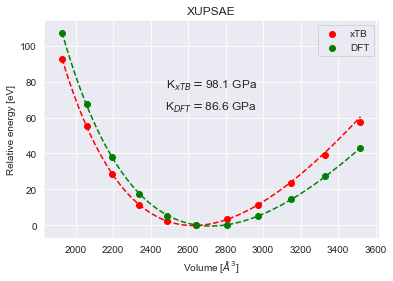

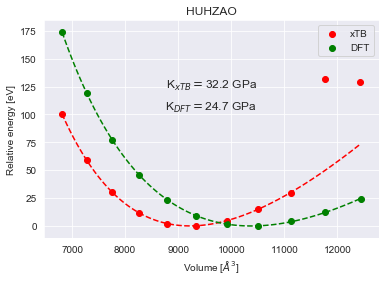

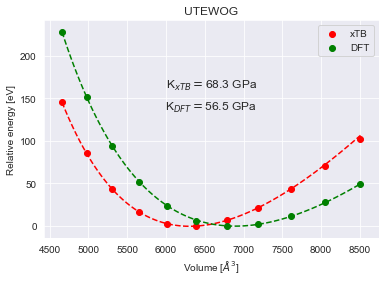

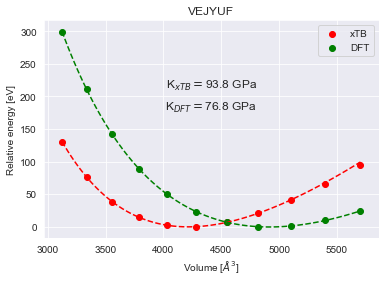

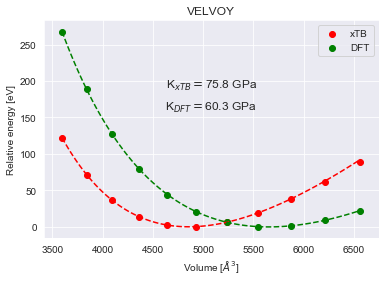

In [16]:
for name in names_converged_new:
    try:
        # xTB
        fig, ax = plt.subplots()
        vols = df_xtb.loc[df_xtb["name"]==name]["volume"]
        energies = df_xtb.loc[df_xtb["name"]==name]["energy [kcal/mol]"]*kcalmol2ev
        v_e = np.vstack([vols,energies]).T
        v_e = v_e[v_e[:, 0].argsort()]
        eos_system = eos.EOS(eos_name='murnaghan')
        eos_fit = eos_system.fit(v_e[:-3,0], v_e[:-3,1])
        ax.scatter(vols,energies-np.min(energies),c="r",label = "xTB")
        xr = np.linspace(min(vols),max(vols),100)
        ax.plot(xr,eos_fit.func(xr)-np.min(energies),"--r")
        # dft
        vols = df_dft.loc[df_dft["name"]==name]["volume"]
        energies = df_dft.loc[df_dft["name"]==name]["energy [kcal/mol]"]*kcalmol2ev
        eos_system = eos.EOS(eos_name='murnaghan')
        eos_fit = eos_system.fit(vols, energies)
        ax.scatter(vols,energies-np.min(energies),c="g",label = "DFT")
        xr = np.linspace(min(vols),max(vols),100)
        ax.plot(xr,eos_fit.func(xr)-np.min(energies),"--g")
        plt.title(name)
        plt.xlabel(r"Volume [$\AA^3$]")
        plt.ylabel(r"Relative energy [eV]")
        ax.text(0.5, 0.7, r'K$_{xTB} = $%4.1f GPa'%df_xtb.loc[df_xtb["name"]==name]["Bulk modulus [GPa]"].values[0] , fontsize=12, horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.5, 0.6, r'K$_{DFT} = $%4.1f GPa'%df_dft.loc[df_dft["name"]==name]["Bulk modulus [GPa]"].values[0] , fontsize=12, horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes)
        ax.legend()
        plt.savefig("EOS/eos_%s.pdf"%name)
        plt.savefig("EOS/eos_%s.png"%name,dpi=600,bbox_inches="tight")
    except:
        print(name)
        continue
    

In [14]:
print(failed)

['UPOZAB', 'BOHWIG']


In [17]:
print(names_converged_new)

['DOYBEA', 'ORIVOC', 'VOGTIV', 'FUNBOG', 'SAHYIK', 'VEBHUG', 'OLEYAH', 'RUBTAK', 'KAXQIL', 'GEBPEK', 'XUPSAE', 'HUHZAO', 'UTEWOG', 'VEJYUF', 'VELVOY']


In [18]:
print(len(names_converged_new))

15
